CT Reconstruction (ADMM Plug-and-Play Priors w/ BM3D, SVMBIR+Prox)
==================================================================

This example demonstrates the use of class
[admm.ADMM](../_autosummary/scico.optimize.rst#scico.optimize.ADMM) to
solve a tomographic reconstruction problem using the Plug-and-Play Priors
framework <cite data-cite="venkatakrishnan-2013-plugandplay2"/>, using BM3D
<cite data-cite="dabov-2008-image"/> as a denoiser and SVMBIR <cite data-cite="svmbir-2020"/> for
tomographic projection.

This version uses the data fidelity term as one of the ADMM $g$
functionals so that the optimization with respect to the data fidelity is
able to exploit the internal prox of the `SVMBIRExtendedLoss` and
`SVMBIRSquaredL2Loss` functionals.

We solve the problem in two different ways:
1. Using the `SVMBIRSquaredL2Loss` together with the BM3D pseudo-functional
   and a non-negative indicator function, and
2. Using the `SVMBIRExtendedLoss`, which includes a non-negativity
   constraint, together with the BM3D pseudo-functional.

In [1]:
import numpy as np

import jax

import matplotlib.pyplot as plt
import svmbir
from matplotlib.ticker import MaxNLocator
from xdesign import Foam, discrete_phantom

import scico.numpy as snp
from scico import metric, plot
from scico.functional import BM3D, NonNegativeIndicator
from scico.linop import Diagonal, Identity
from scico.linop.radon_svmbir import (
    ParallelBeamProjector,
    SVMBIRExtendedLoss,
    SVMBIRSquaredL2Loss,
)
from scico.optimize.admm import ADMM, LinearSubproblemSolver
from scico.util import device_info
plot.config_notebook_plotting()

Generate a ground truth image.

In [2]:
N = 256  # image size
density = 0.025  # attenuation density of the image
np.random.seed(1234)
x_gt = discrete_phantom(Foam(size_range=[0.05, 0.02], gap=0.02, porosity=0.3), size=N - 10)
x_gt = x_gt / np.max(x_gt) * density
x_gt = np.pad(x_gt, 5)
x_gt[x_gt < 0] = 0

Generate tomographic projector and sinogram.

In [3]:
num_angles = int(N / 2)
num_channels = N
angles = snp.linspace(0, snp.pi, num_angles, endpoint=False, dtype=snp.float32)
A = ParallelBeamProjector(x_gt.shape, angles, num_channels)
sino = A @ x_gt

Impose Poisson noise on sinogram. Higher max_intensity means less noise.

In [4]:
max_intensity = 2000
expected_counts = max_intensity * np.exp(-sino)
noisy_counts = np.random.poisson(expected_counts).astype(np.float32)
noisy_counts[noisy_counts == 0] = 1  # deal with 0s
y = -np.log(noisy_counts / max_intensity)

Reconstruct using default prior of SVMBIR <cite data-cite="svmbir-2020"/>.

In [5]:
weights = svmbir.calc_weights(y, weight_type="transmission")

x_mrf = svmbir.recon(
    np.array(y[:, np.newaxis]),
    np.array(angles),
    weights=weights[:, np.newaxis],
    num_rows=N,
    num_cols=N,
    positivity=True,
    verbose=0,
)[0]

Push arrays to device.

In [6]:
y, x0, weights = jax.device_put([y, x_mrf, weights])

Set problem parameters and BM3D pseudo-functional.

In [7]:
ρ = 10  # ADMM penalty parameter
σ = density * 0.26  # denoiser sigma
g0 = σ * ρ * BM3D()

Set up problem using `SVMBIRSquaredL2Loss` and `NonNegativeIndicator`.

In [8]:
f_l2loss = SVMBIRSquaredL2Loss(
    y=y, A=A, W=Diagonal(weights), scale=0.5, prox_kwargs={"maxiter": 5, "ctol": 0.0}
)
g1 = NonNegativeIndicator()

solver_l2loss = ADMM(
    f=None,
    g_list=[f_l2loss, g0, g1],
    C_list=[Identity(x_mrf.shape), Identity(x_mrf.shape), Identity(x_mrf.shape)],
    rho_list=[ρ, ρ, ρ],
    x0=x0,
    maxiter=20,
    subproblem_solver=LinearSubproblemSolver(cg_kwargs={"tol": 1e-3, "maxiter": 100}),
    itstat_options={"display": True},
)

Run the ADMM solver.

In [9]:
print(f"Solving on {device_info()}\n")
x_l2loss = solver_l2loss.solve()
hist_l2loss = solver_l2loss.itstat_object.history(transpose=True)

Solving on CPU



Iter  Time      Prml Rsdl  Dual Rsdl  CG It  CG Res   
------------------------------------------------------
   0  2.26e+00  5.375e-01  5.375e-01      0  3.919e-08


   1  4.28e+00  3.687e-01  3.230e-01      1  6.381e-08


   2  6.33e+00  2.416e-01  2.148e-01      1  1.165e-07


   3  8.34e+00  1.574e-01  1.827e-01      1  2.790e-07


   4  1.04e+01  1.189e-01  1.367e-01      1  1.275e-07


   5  1.25e+01  1.016e-01  9.370e-02      1  4.843e-08


   6  1.46e+01  8.629e-02  6.378e-02      1  5.462e-08


   7  1.67e+01  6.846e-02  5.028e-02      1  2.663e-08


   8  1.87e+01  5.311e-02  4.410e-02      1  1.989e-08


   9  2.09e+01  4.391e-02  3.744e-02      1  1.458e-08


  10  2.29e+01  3.904e-02  2.975e-02      1  6.145e-09


  11  2.49e+01  3.555e-02  2.380e-02      1  1.685e-08


  12  2.70e+01  3.218e-02  2.114e-02      1  9.306e-09


  13  2.92e+01  2.889e-02  1.945e-02      1  1.100e-08


  14  3.12e+01  2.651e-02  1.772e-02      1  1.556e-08


  15  3.33e+01  2.456e-02  1.595e-02      1  1.676e-09


  16  3.54e+01  2.340e-02  1.559e-02      1  6.276e-09


  17  3.74e+01  2.181e-02  1.460e-02      1  3.755e-09


  18  3.95e+01  2.066e-02  1.367e-02      1  1.019e-09


  19  4.17e+01  1.955e-02  1.299e-02      1  2.709e-09


Set up problem using `SVMBIRExtendedLoss`, without need for `NonNegativeIndicator`.

In [10]:
f_extloss = SVMBIRExtendedLoss(
    y=y,
    A=A,
    W=Diagonal(weights),
    scale=0.5,
    positivity=True,
    prox_kwargs={"maxiter": 5, "ctol": 0.0},
)

solver_extloss = ADMM(
    f=None,
    g_list=[f_extloss, g0],
    C_list=[Identity(x_mrf.shape), Identity(x_mrf.shape)],
    rho_list=[ρ, ρ],
    x0=x0,
    maxiter=20,
    subproblem_solver=LinearSubproblemSolver(cg_kwargs={"tol": 1e-3, "maxiter": 100}),
    itstat_options={"display": True},
)

Run the ADMM solver.

In [11]:
print()
x_extloss = solver_extloss.solve()
hist_extloss = solver_extloss.itstat_object.history(transpose=True)

Iter  Time      Prml Rsdl  Dual Rsdl  CG It  CG Res   
------------------------------------------------------
   0  2.29e+00  4.720e-01  4.720e-01      0  0.000e+00


   1  4.48e+00  3.472e-01  2.466e-01      1  6.448e-07


   2  6.58e+00  1.691e-01  2.115e-01      1  3.536e-07


   3  8.62e+00  1.024e-01  1.473e-01      1  1.240e-08


   4  1.07e+01  8.591e-02  8.328e-02      1  2.003e-07


   5  1.27e+01  6.648e-02  4.819e-02      1  9.768e-08


   6  1.48e+01  4.640e-02  3.761e-02      1  1.302e-07


   7  1.69e+01  3.422e-02  3.056e-02      1  8.322e-08


   8  1.89e+01  2.929e-02  2.325e-02      1  2.481e-08


   9  2.10e+01  2.590e-02  1.762e-02      1  6.929e-08


  10  2.30e+01  2.285e-02  1.492e-02      1  2.454e-08


  11  2.51e+01  2.052e-02  1.312e-02      1  8.465e-09


  12  2.71e+01  1.880e-02  1.132e-02      1  1.366e-08


  13  2.92e+01  1.744e-02  1.033e-02      1  2.326e-08


  14  3.12e+01  1.642e-02  9.394e-03      1  8.668e-09


  15  3.33e+01  1.555e-02  8.871e-03      1  6.626e-09


  16  3.53e+01  1.496e-02  8.678e-03      1  2.978e-08


  17  3.74e+01  1.414e-02  8.290e-03      1  4.004e-08


  18  3.94e+01  1.362e-02  8.027e-03      1  1.264e-08


  19  4.14e+01  1.320e-02  7.804e-03      1  1.045e-09


Show the recovered images.

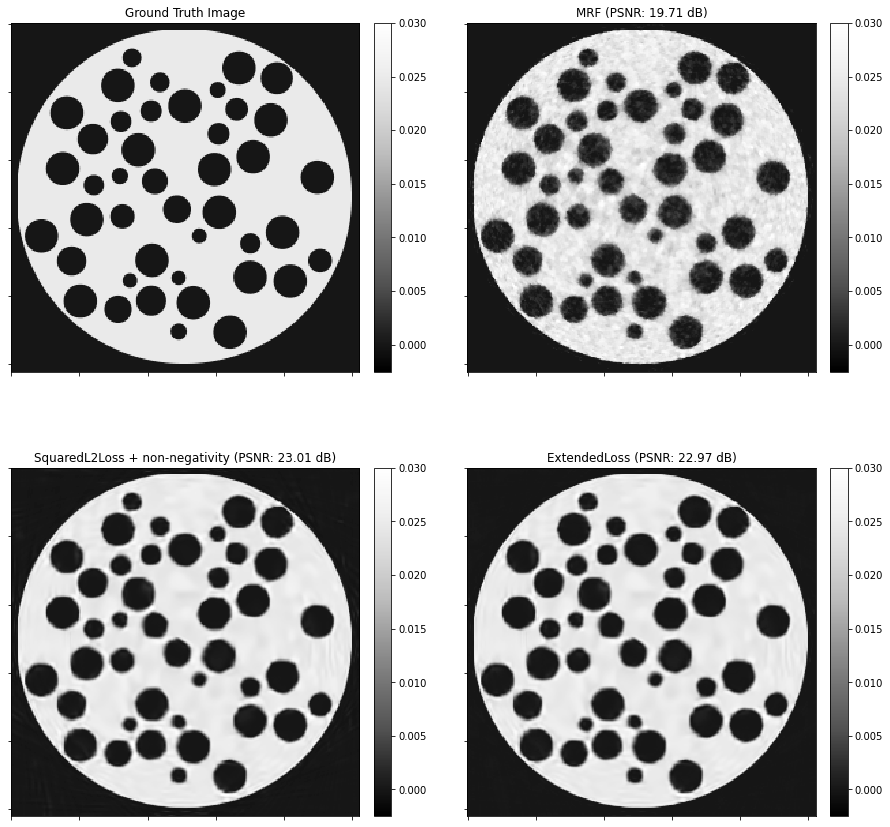

In [12]:
norm = plot.matplotlib.colors.Normalize(vmin=-0.1 * density, vmax=1.2 * density)
fig, ax = plt.subplots(2, 2, figsize=(15, 15))
plot.imview(img=x_gt, title="Ground Truth Image", cbar=True, fig=fig, ax=ax[0, 0], norm=norm)
plot.imview(
    img=x_mrf,
    title=f"MRF (PSNR: {metric.psnr(x_gt, x_mrf):.2f} dB)",
    cbar=True,
    fig=fig,
    ax=ax[0, 1],
    norm=norm,
)
plot.imview(
    img=x_l2loss,
    title=f"SquaredL2Loss + non-negativity (PSNR: {metric.psnr(x_gt, x_l2loss):.2f} dB)",
    cbar=True,
    fig=fig,
    ax=ax[1, 0],
    norm=norm,
)
plot.imview(
    img=x_extloss,
    title=f"ExtendedLoss (PSNR: {metric.psnr(x_gt, x_extloss):.2f} dB)",
    cbar=True,
    fig=fig,
    ax=ax[1, 1],
    norm=norm,
)
fig.show()

Plot convergence statistics.

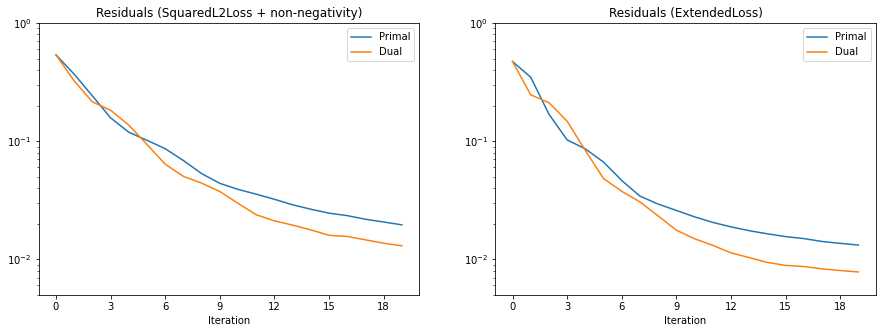

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
plot.plot(
    snp.vstack((hist_l2loss.Prml_Rsdl, hist_l2loss.Dual_Rsdl)).T,
    ptyp="semilogy",
    title="Residuals (SquaredL2Loss + non-negativity)",
    xlbl="Iteration",
    lgnd=("Primal", "Dual"),
    fig=fig,
    ax=ax[0],
)
ax[0].set_ylim([5e-3, 1e0])
ax[0].xaxis.set_major_locator(MaxNLocator(integer=True))
plot.plot(
    snp.vstack((hist_extloss.Prml_Rsdl, hist_extloss.Dual_Rsdl)).T,
    ptyp="semilogy",
    title="Residuals (ExtendedLoss)",
    xlbl="Iteration",
    lgnd=("Primal", "Dual"),
    fig=fig,
    ax=ax[1],
)
ax[1].set_ylim([5e-3, 1e0])
ax[1].xaxis.set_major_locator(MaxNLocator(integer=True))
fig.show()